## TabNet-Optunaのサンプルコード

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from pytorch_tabnet.tab_model import TabNetRegressor

import os
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Optuna
import optuna
from optuna.samplers import TPESampler

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

In [3]:
print(torch.__version__)

1.9.0+cu102


In [4]:
print(optuna.__version__)

2.8.0


In [5]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


seed_everything(10)

In [6]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [7]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

# trainのデータセットの2割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [8]:
def objective(trial):

    params = {
        "n_d": trial.suggest_int("n_d", 5, 50),
        "n_a": trial.suggest_int("n_a", 5, 50),
        "gamma": trial.suggest_loguniform("gamma", 0.1, 3.0),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-4, 1e-2),
        "verbose": 10,
        "optimizer_fn": torch.optim.Adam,
        "n_steps": 3,
        "optimizer_params": dict(lr=2e-2, weight_decay=1e-5),
        "mask_type": "entmax",
        "scheduler_params": dict(
            max_lr=0.05,
            steps_per_epoch=int(x_train.shape[0] / 256),
            epochs=200,
            is_batch_level=True,
        ),
    }

    model = TabNetRegressor(**params)

    model.fit(
        X_train=x_train.values,
        y_train=y_train.values.reshape(-1, 1),
        eval_set=[(x_valid.values, y_valid.values.reshape(-1, 1))],
        eval_metric=["mae"],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=2,
        drop_last=False,
        loss_fn=torch.nn.functional.l1_loss,
    )

    preds = model.predict(x_valid.values)
    mae = mean_absolute_error(y_valid, preds)

    return mae

In [9]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=10)

[I 2021-07-31 11:48:06,245] A new study created in memory with name: no-name-d95d1298-2938-42d0-8b7d-732079067359


Device used : cpu
epoch 0  | loss: 22.7679 | val_0_mae: 40.90259|  0:00:00s
epoch 10 | loss: 4.21328 | val_0_mae: 62.5233 |  0:00:05s
epoch 20 | loss: 2.35183 | val_0_mae: 43.92477|  0:00:11s
epoch 30 | loss: 2.20052 | val_0_mae: 21.23734|  0:00:16s
epoch 40 | loss: 1.61622 | val_0_mae: 10.12478|  0:00:22s
epoch 50 | loss: 1.97044 | val_0_mae: 6.83528 |  0:00:28s
epoch 60 | loss: 1.54354 | val_0_mae: 8.15627 |  0:00:34s
epoch 70 | loss: 1.47282 | val_0_mae: 4.60807 |  0:00:40s
epoch 80 | loss: 1.37619 | val_0_mae: 5.83964 |  0:00:47s
epoch 90 | loss: 1.37753 | val_0_mae: 3.84597 |  0:00:56s
epoch 100| loss: 1.46985 | val_0_mae: 3.816   |  0:01:03s
epoch 110| loss: 1.48347 | val_0_mae: 3.11394 |  0:01:09s
epoch 120| loss: 1.35678 | val_0_mae: 2.4971  |  0:01:16s
epoch 130| loss: 1.16589 | val_0_mae: 2.88603 |  0:01:23s

Early stopping occurred at epoch 134 with best_epoch = 114 and best_val_0_mae = 2.4331
Best weights from best epoch are automatically used!


[I 2021-07-31 11:49:32,727] Trial 0 finished with value: 2.4331024252338174 and parameters: {'n_d': 40, 'n_a': 5, 'gamma': 0.8629294202140577, 'lambda_sparse': 0.0031449066951230948}. Best is trial 0 with value: 2.4331024252338174.


Device used : cpu
epoch 0  | loss: 21.84247| val_0_mae: 55.07674|  0:00:00s
epoch 10 | loss: 4.46036 | val_0_mae: 105.10366|  0:00:06s
epoch 20 | loss: 2.26697 | val_0_mae: 21.58229|  0:00:12s
epoch 30 | loss: 1.99261 | val_0_mae: 24.43938|  0:00:19s

Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_mae = 11.88037
Best weights from best epoch are automatically used!


[I 2021-07-31 11:49:55,608] Trial 1 finished with value: 11.880366280638142 and parameters: {'n_d': 27, 'n_a': 15, 'gamma': 0.19613850797827748, 'lambda_sparse': 0.003319414023327547}. Best is trial 0 with value: 2.4331024252338174.


Device used : cpu
epoch 0  | loss: 20.96321| val_0_mae: 27.56122|  0:00:00s
epoch 10 | loss: 6.81238 | val_0_mae: 50.40458|  0:00:05s
epoch 20 | loss: 3.12119 | val_0_mae: 18.27043|  0:00:10s

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_mae = 18.15217
Best weights from best epoch are automatically used!


[I 2021-07-31 11:50:08,055] Trial 2 finished with value: 18.152172086268298 and parameters: {'n_d': 12, 'n_a': 9, 'gamma': 1.0288677510088238, 'lambda_sparse': 0.008068386469121065}. Best is trial 0 with value: 2.4331024252338174.


Device used : cpu
epoch 0  | loss: 21.82856| val_0_mae: 31.00052|  0:00:00s
epoch 10 | loss: 12.27143| val_0_mae: 26.92937|  0:00:06s
epoch 20 | loss: 3.8001  | val_0_mae: 31.47435|  0:00:12s
epoch 30 | loss: 2.51574 | val_0_mae: 9.44239 |  0:00:18s
epoch 40 | loss: 2.03615 | val_0_mae: 6.18593 |  0:00:24s
epoch 50 | loss: 2.04734 | val_0_mae: 6.03398 |  0:00:30s
epoch 60 | loss: 1.98534 | val_0_mae: 6.49484 |  0:00:36s

Early stopping occurred at epoch 65 with best_epoch = 45 and best_val_0_mae = 5.12691
Best weights from best epoch are automatically used!


[I 2021-07-31 11:50:47,527] Trial 3 finished with value: 5.126912407816192 and parameters: {'n_d': 5, 'n_a': 28, 'gamma': 1.586133341970331, 'lambda_sparse': 0.0016790055575223667}. Best is trial 0 with value: 2.4331024252338174.


Device used : cpu
epoch 0  | loss: 20.72869| val_0_mae: 43.12592|  0:00:00s
epoch 10 | loss: 4.83951 | val_0_mae: 16.79277|  0:00:07s
epoch 20 | loss: 2.70506 | val_0_mae: 24.9105 |  0:00:14s
epoch 30 | loss: 2.48422 | val_0_mae: 9.60446 |  0:00:21s
epoch 40 | loss: 2.2644  | val_0_mae: 9.18278 |  0:00:29s
epoch 50 | loss: 1.97803 | val_0_mae: 6.36073 |  0:00:35s
epoch 60 | loss: 1.69202 | val_0_mae: 5.8152  |  0:00:42s
epoch 70 | loss: 2.00621 | val_0_mae: 7.03142 |  0:00:49s
epoch 80 | loss: 1.9251  | val_0_mae: 7.05977 |  0:00:55s
epoch 90 | loss: 1.75756 | val_0_mae: 4.47352 |  0:01:03s
epoch 100| loss: 1.68476 | val_0_mae: 3.66868 |  0:01:10s
epoch 110| loss: 1.79395 | val_0_mae: 3.59806 |  0:01:16s
epoch 120| loss: 1.56067 | val_0_mae: 3.00987 |  0:01:23s
epoch 130| loss: 1.42273 | val_0_mae: 2.97925 |  0:01:29s
epoch 140| loss: 1.68014 | val_0_mae: 2.70599 |  0:01:36s
epoch 150| loss: 1.41734 | val_0_mae: 2.3334  |  0:01:43s
epoch 160| loss: 1.38481 | val_0_mae: 2.10847 |  0:01:

[I 2021-07-31 11:52:49,821] Trial 4 finished with value: 1.9588072965174546 and parameters: {'n_d': 38, 'n_a': 18, 'gamma': 2.268107649974001, 'lambda_sparse': 0.002686281782188217}. Best is trial 4 with value: 1.9588072965174546.


Device used : cpu
epoch 0  | loss: 19.89658| val_0_mae: 105.77685|  0:00:00s
epoch 10 | loss: 3.17664 | val_0_mae: 21.6491 |  0:00:06s
epoch 20 | loss: 2.29809 | val_0_mae: 23.82159|  0:00:11s
epoch 30 | loss: 2.07887 | val_0_mae: 12.64586|  0:00:17s
epoch 40 | loss: 2.15308 | val_0_mae: 13.4878 |  0:00:22s
epoch 50 | loss: 1.59418 | val_0_mae: 9.86579 |  0:00:28s
epoch 60 | loss: 1.54028 | val_0_mae: 6.11342 |  0:00:33s
epoch 70 | loss: 1.63857 | val_0_mae: 5.2096  |  0:00:39s
epoch 80 | loss: 1.39359 | val_0_mae: 3.64005 |  0:00:44s
epoch 90 | loss: 1.46762 | val_0_mae: 3.837   |  0:00:50s
epoch 100| loss: 1.47768 | val_0_mae: 3.6147  |  0:00:55s
epoch 110| loss: 1.47219 | val_0_mae: 3.50861 |  0:01:01s
epoch 120| loss: 1.27156 | val_0_mae: 2.91793 |  0:01:08s

Early stopping occurred at epoch 126 with best_epoch = 106 and best_val_0_mae = 2.64943
Best weights from best epoch are automatically used!


[I 2021-07-31 11:54:02,357] Trial 5 finished with value: 2.6494294613967706 and parameters: {'n_d': 29, 'n_a': 11, 'gamma': 0.356016045527541, 'lambda_sparse': 0.0022298067722039327}. Best is trial 4 with value: 1.9588072965174546.


Device used : cpu
epoch 0  | loss: 22.3206 | val_0_mae: 44.88022|  0:00:00s
epoch 10 | loss: 3.14359 | val_0_mae: 68.17351|  0:00:06s
epoch 20 | loss: 2.11892 | val_0_mae: 10.77115|  0:00:12s
epoch 30 | loss: 2.01255 | val_0_mae: 9.89513 |  0:00:18s
epoch 40 | loss: 2.04396 | val_0_mae: 9.65489 |  0:00:24s

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_mae = 8.94326
Best weights from best epoch are automatically used!


[I 2021-07-31 11:54:28,877] Trial 6 finished with value: 8.943258657573182 and parameters: {'n_d': 25, 'n_a': 24, 'gamma': 0.8175545395854358, 'lambda_sparse': 0.0010623716801588566}. Best is trial 4 with value: 1.9588072965174546.


Device used : cpu
epoch 0  | loss: 21.15963| val_0_mae: 146.29139|  0:00:00s
epoch 10 | loss: 3.91568 | val_0_mae: 23.65176|  0:00:07s
epoch 20 | loss: 2.74638 | val_0_mae: 20.14294|  0:00:13s
epoch 30 | loss: 2.39482 | val_0_mae: 7.70866 |  0:00:20s
epoch 40 | loss: 2.37993 | val_0_mae: 14.21459|  0:00:26s
epoch 50 | loss: 2.13163 | val_0_mae: 7.32808 |  0:00:33s
epoch 60 | loss: 2.18431 | val_0_mae: 7.46923 |  0:00:40s
epoch 70 | loss: 1.88602 | val_0_mae: 4.16121 |  0:00:46s
epoch 80 | loss: 1.72682 | val_0_mae: 3.45903 |  0:00:53s
epoch 90 | loss: 1.53919 | val_0_mae: 3.39517 |  0:01:00s

Early stopping occurred at epoch 95 with best_epoch = 75 and best_val_0_mae = 3.22822
Best weights from best epoch are automatically used!


[I 2021-07-31 11:55:32,855] Trial 7 finished with value: 3.2282240785198444 and parameters: {'n_d': 34, 'n_a': 32, 'gamma': 1.5467221282773012, 'lambda_sparse': 0.0011048270653924235}. Best is trial 4 with value: 1.9588072965174546.


Device used : cpu
epoch 0  | loss: 17.9247 | val_0_mae: 128.38077|  0:00:00s
epoch 10 | loss: 2.72217 | val_0_mae: 89.21731|  0:00:07s
epoch 20 | loss: 1.91235 | val_0_mae: 7.3263  |  0:00:13s
epoch 30 | loss: 2.1191  | val_0_mae: 5.61064 |  0:00:20s
epoch 40 | loss: 2.31603 | val_0_mae: 4.77978 |  0:00:27s
epoch 50 | loss: 1.91805 | val_0_mae: 4.8321  |  0:00:33s
epoch 60 | loss: 1.73187 | val_0_mae: 4.16606 |  0:00:41s
epoch 70 | loss: 1.37967 | val_0_mae: 3.95917 |  0:00:48s
epoch 80 | loss: 1.65535 | val_0_mae: 4.71836 |  0:00:55s

Early stopping occurred at epoch 87 with best_epoch = 67 and best_val_0_mae = 3.51779
Best weights from best epoch are automatically used!


[I 2021-07-31 11:56:33,511] Trial 8 finished with value: 3.517786529917776 and parameters: {'n_d': 46, 'n_a': 19, 'gamma': 0.13602521702849252, 'lambda_sparse': 0.00039939269134736086}. Best is trial 4 with value: 1.9588072965174546.


Device used : cpu
epoch 0  | loss: 21.29005| val_0_mae: 64.90809|  0:00:00s
epoch 10 | loss: 5.91848 | val_0_mae: 81.30424|  0:00:06s
epoch 20 | loss: 2.39255 | val_0_mae: 5.28964 |  0:00:13s
epoch 30 | loss: 1.83312 | val_0_mae: 4.2412  |  0:00:19s
epoch 40 | loss: 1.98526 | val_0_mae: 3.3113  |  0:00:25s
epoch 50 | loss: 1.891   | val_0_mae: 2.95428 |  0:00:31s
epoch 60 | loss: 1.56839 | val_0_mae: 2.93291 |  0:00:37s
epoch 70 | loss: 1.48707 | val_0_mae: 3.1908  |  0:00:43s
epoch 80 | loss: 1.70756 | val_0_mae: 3.08645 |  0:00:50s
epoch 90 | loss: 1.19241 | val_0_mae: 3.01737 |  0:00:56s
epoch 100| loss: 1.33185 | val_0_mae: 2.65588 |  0:01:02s
epoch 110| loss: 1.20445 | val_0_mae: 2.36748 |  0:01:08s
epoch 120| loss: 1.34791 | val_0_mae: 2.18636 |  0:01:14s
epoch 130| loss: 1.1114  | val_0_mae: 2.19475 |  0:01:20s
epoch 140| loss: 1.31761 | val_0_mae: 1.95532 |  0:01:26s
epoch 150| loss: 1.20803 | val_0_mae: 1.95928 |  0:01:32s
epoch 160| loss: 1.16151 | val_0_mae: 1.96178 |  0:01:

[I 2021-07-31 11:58:13,198] Trial 9 finished with value: 1.8722021291285387 and parameters: {'n_d': 10, 'n_a': 43, 'gamma': 0.11729285301671351, 'lambda_sparse': 0.0017888515294488302}. Best is trial 9 with value: 1.8722021291285387.


CPU times: user 9min 51s, sys: 5min 26s, total: 15min 17s
Wall time: 10min 6s


In [10]:
best_params = study.best_params
best_params["verbose"] = 10
best_params["seed"] = RANDOM_STATE
best_params

{'n_d': 10,
 'n_a': 43,
 'gamma': 0.11729285301671351,
 'lambda_sparse': 0.0017888515294488302,
 'verbose': 10,
 'seed': 10}

In [11]:
# チューニングしたハイパーパラメーターをフィット
optimised_model = TabNetRegressor(**(best_params))

optimised_model.fit(
    X_train=x_train.values,
    y_train=y_train.values.reshape(-1, 1),
    eval_set=[(x_valid.values, y_valid.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=2,
    drop_last=False,
)

# TabNet推論
y_pred = optimised_model.predict(x_test.values)

Device used : cpu
epoch 0  | loss: 585.91789| val_0_mae: 42.05549|  0:00:00s
epoch 10 | loss: 186.74784| val_0_mae: 13.92923|  0:00:06s
epoch 20 | loss: 17.17089| val_0_mae: 17.68082|  0:00:13s
epoch 30 | loss: 10.00062| val_0_mae: 12.4755 |  0:00:19s
epoch 40 | loss: 7.34721 | val_0_mae: 6.65255 |  0:00:25s
epoch 50 | loss: 3.53316 | val_0_mae: 5.3664  |  0:00:31s
epoch 60 | loss: 4.61554 | val_0_mae: 5.02695 |  0:00:37s
epoch 70 | loss: 6.70072 | val_0_mae: 4.51143 |  0:00:43s
epoch 80 | loss: 5.07985 | val_0_mae: 3.87724 |  0:00:50s
epoch 90 | loss: 3.10121 | val_0_mae: 3.23605 |  0:00:57s
epoch 100| loss: 1.81788 | val_0_mae: 3.08854 |  0:01:04s
epoch 110| loss: 2.95389 | val_0_mae: 2.95756 |  0:01:10s
epoch 120| loss: 2.59077 | val_0_mae: 2.7542  |  0:01:16s
epoch 130| loss: 1.83195 | val_0_mae: 2.40735 |  0:01:22s
epoch 140| loss: 2.607   | val_0_mae: 2.35547 |  0:01:28s
epoch 150| loss: 3.09471 | val_0_mae: 2.15651 |  0:01:34s
epoch 160| loss: 2.02477 | val_0_mae: 2.16755 |  0:0

In [12]:
# Feature Importance
optimised_model.feature_importances_

array([0.09074585, 0.10229269, 0.05052711, 0.03352392, 0.0678532 ,
       0.05197916, 0.12070454, 0.04905348, 0.06151632, 0.1100651 ,
       0.05309462, 0.08661833, 0.12202567])

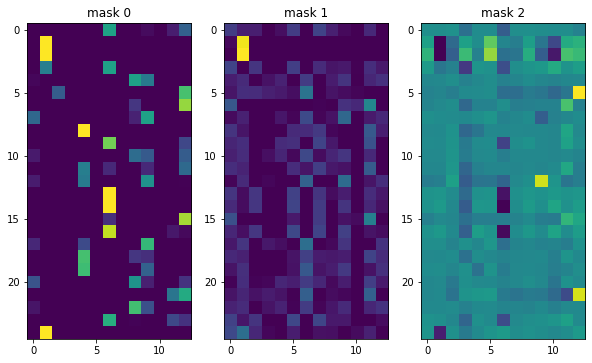

In [13]:
# Mask(Local interpretability)
explain_matrix, masks = optimised_model.explain(x_test.values)

fig, axs = plt.subplots(1, 3, figsize=(10, 7))

for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")

In [14]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [15]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE     RMSE
scores  0.866519  2.689502  13.959562  3.73625
